In [1]:
#__autho__:KK
#__date__:Apr27
# this notebook merges pluto, census tract, and noise complaint data into single files based on time
# please refer corresponding cells and copy paste to the head of your notebook to avoid redundant data cleaning!
import pandas as pd
import numpy as np
import os
cwd = os.getcwd()

### copied from claire's code

In [2]:
ct = pd.read_csv('../data/boroct_ct_merge.csv')
bbl = pd.read_csv('../data/bbl_c_ct_pop.csv')

output_path = os.path.join(os.path.dirname(cwd), 'output')
data_path = os.path.join(os.path.dirname(cwd), 'data')

In [3]:
ct = ct.drop('Unnamed: 0',axis=1)
bbl = bbl.drop(['Unnamed: 0', 'Complaint Count'],axis=1)

In [4]:
file_name = ['reduce_year_ct.txt', 'reduce_month_ct.txt', 'reduce_hour_ct.txt', 'reduce_ct.txt', 'reduce_day_ct.txt']

In [5]:
data = {}
level = ['year', 'month', 'hour', 'all', 'day']
for i in range(3):
    dt = np.loadtxt(os.path.join(output_path,file_name[i]), str)
    dt = dt[dt != '''(NR10)"'),''']
    data1 = pd.DataFrame(dt.reshape((dt.shape[0]/3 ,3)), columns=[level[i], 'ct', 'count'])
    data1.iloc[0,0] = data1.iloc[0,0][1:]
    data1.iloc[-1,-1] = data1.iloc[-1,-1][:-1]
    year_list = data1.apply(lambda x: int(x[0][2:-1].replace('(','')), axis = 1)
    zipcode_list = data1.apply(lambda x: x[1][2:-3], axis = 1)
    counts_list = data1.apply(lambda x: int(x[2][:-2].replace(')','')), axis = 1)
    
    data_ = pd.DataFrame({level[i]: year_list, 'ct':zipcode_list, 'counts': counts_list})
    data[level[i]] = data_

### merge features and count of complaints

In [6]:
bbl['GEOID'] = bbl['GEOID'].astype(str)
ct['GEOID'] = ct['GEOID'].astype(str)

In [7]:
features = pd.merge(ct, bbl, on='GEOID')

In [8]:
features.head()

,GEOID,BoroCT2010,BldgAge,NumFloors,AssessTot,BldgArea,BldgDepth,BldgFront,ComArea,FactryArea,GarageArea,NumBldgs,OfficeArea,OtherArea,StrgeArea,StrgeArea.1,Population
0,36005002701,2002701,88.800000,4.233333,6.938555e+05,48279.733333,81.239000,57.386000,5442.000000,1208.333333,158.333333,1.366667,299.466667,8.666667,0.000000,0.000000,3016.0
1,36005003300,2003300,52.786585,3.131098,3.080311e+05,10604.829268,50.717500,35.610061,3262.195122,1602.042683,54.054878,1.073171,194.512195,658.060976,709.707317,709.707317,3912.0
2,36005003500,2003500,84.161290,3.020161,4.463263e+05,15322.701613,69.696129,48.383145,5705.177419,1824.822581,298.040323,1.225806,285.838710,2301.564516,396.548387,396.548387,3948.0
3,36005003700,2003700,51.142857,4.547619,1.488484e+06,41197.428571,63.452857,52.713810,3206.142857,0.000000,0.000000,1.238095,0.000000,2987.095238,0.000000,0.000000,246.0
4,36005003800,2003800,62.634328,2.317164,3.815140e+04,2924.626866,42.661716,22.343881,34.701493,0.000000,0.000000,1.119403,0.000000,34.701493,0.000000,0.000000,1193.0


In [9]:
print len(features.GEOID.unique())

2159


In [10]:
features = features.drop(['StrgeArea.1', 'FactryArea', 'GarageArea', 'OfficeArea', 'StrgeArea', 'OtherArea'],axis=1)

In [11]:
demo = pd.read_csv('../data/demo_boroct_merged_data.csv')

In [12]:
earn = pd.read_csv('../data/ACS_15_5YR_S1903/ACS_15_5YR_S1903_with_ann.csv',header=1)
earn = earn[['Id2', 'Median income (dollars); Estimate; Households']]
earn = earn.rename(columns={'Median income (dollars); Estimate; Households':'median_hh_inc'})
earn.head(2)

,Id2,median_hh_inc
0,36005000100,-
1,36005000200,72034


In [13]:
earn['median_hh_inc'] = pd.to_numeric(earn['median_hh_inc'], errors='coerce')

In [14]:
earn.isnull().sum()

Id2               0
median_hh_inc    66
dtype: int64

In [15]:
gender = demo[['GEO.id2', 'Female; Estimate; Total population']]
gender = gender.rename(columns={'Female; Estimate; Total population':'female_pop'})

In [16]:
gender.head(2)

,GEO.id2,female_pop
0,36005002701,1641
1,36005003300,2088


In [17]:
gender.isnull().sum()

GEO.id2       0
female_pop    0
dtype: int64

In [18]:
race = demo[['GEO.id2', u'Total; Estimate; White alone, not Hispanic or Latino',
       u'Total; Estimate; Black alone',
       u'Total; Estimate; American Indian or Alaska Native alone',
       u'Total; Estimate; Asian alone',
       u'Total; Estimate; Native Hawaiian and Other Pacific Islander alone',
       u'Total; Estimate; Some other race alone',
       u'Total; Estimate; Two or more races',
       u'Total; Estimate; Hispanic or Latino Origin']]
race = race.rename(columns={u'Total; Estimate; White alone, not Hispanic or Latino':'white_pop',
       u'Total; Estimate; Black alone':'black_pop',
       u'Total; Estimate; American Indian or Alaska Native alone':'native_pop',
       u'Total; Estimate; Asian alone':'asian_pop',
       u'Total; Estimate; Native Hawaiian and Other Pacific Islander alone':'islander_pop',
       u'Total; Estimate; Some other race alone':'otherrace_pop',
       u'Total; Estimate; Two or more races':'tworaces_pop',
       u'Total; Estimate; Hispanic or Latino Origin':'hisplat_pop'})

In [19]:
age = demo[['GEO.id2', 'Total; Estimate; Population 65 years and over']]
age = age.rename(columns={'Total; Estimate; Population 65 years and over':'elderly_pop'})

In [20]:
age['GEO.id2'] = age['GEO.id2'].astype(str)
earn['Id2'] = earn['Id2'].astype(str)
demo = pd.merge(age, earn, left_on='GEO.id2', right_on='Id2')
print len(demo.Id2.unique())

2167


In [21]:
gender['GEO.id2'] = gender['GEO.id2'].astype(str)
demo = pd.merge(gender, demo, on='GEO.id2')
print len(demo.Id2.unique())

2167


In [22]:
race['GEO.id2'] = race['GEO.id2'].astype(str)
demo = pd.merge(race, demo, on='GEO.id2')
print len(demo.Id2.unique())

2167


In [23]:
demo = demo.drop('Id2',axis=1)
demo.head()

,GEO.id2,white_pop,black_pop,native_pop,asian_pop,islander_pop,otherrace_pop,tworaces_pop,hisplat_pop,female_pop,elderly_pop,median_hh_inc
0,36005002701,0,560,0,0,0,753,26,1160,1641,189,20153.0
1,36005003300,24,716,31,0,0,838,38,1421,2088,244,19923.0
2,36005003500,16,808,18,0,0,1266,69,1702,2027,350,26541.0
3,36005003700,44,34,0,0,0,77,0,106,118,5,NaN
4,36005003800,14,380,0,15,0,172,15,428,651,157,37685.0


In [24]:
demo['GEO.id2'] = demo['GEO.id2'].astype(str)
features['GEOID'] = features['GEOID'].astype(str)
features = pd.merge(features, demo, left_on='GEOID', right_on='GEO.id2')

In [25]:
features = features.drop(['GEOID','GEO.id2'],axis=1)
features.head()

,BoroCT2010,BldgAge,NumFloors,AssessTot,BldgArea,BldgDepth,BldgFront,ComArea,NumBldgs,Population,...,black_pop,native_pop,asian_pop,islander_pop,otherrace_pop,tworaces_pop,hisplat_pop,female_pop,elderly_pop,median_hh_inc
0,2002701,88.800000,4.233333,6.938555e+05,48279.733333,81.239000,57.386000,5442.000000,1.366667,3016.0,...,560,0,0,0,753,26,1160,1641,189,20153.0
1,2003300,52.786585,3.131098,3.080311e+05,10604.829268,50.717500,35.610061,3262.195122,1.073171,3912.0,...,716,31,0,0,838,38,1421,2088,244,19923.0
2,2003500,84.161290,3.020161,4.463263e+05,15322.701613,69.696129,48.383145,5705.177419,1.225806,3948.0,...,808,18,0,0,1266,69,1702,2027,350,26541.0
3,2003700,51.142857,4.547619,1.488484e+06,41197.428571,63.452857,52.713810,3206.142857,1.238095,246.0,...,34,0,0,0,77,0,106,118,5,NaN
4,2003800,62.634328,2.317164,3.815140e+04,2924.626866,42.661716,22.343881,34.701493,1.119403,1193.0,...,380,0,15,0,172,15,428,651,157,37685.0


In [26]:
features = features.convert_objects(convert_numeric=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [27]:
features = features[features['Population']>0]

In [28]:
features.iloc[:,10:].head()

,white_pop,black_pop,native_pop,asian_pop,islander_pop,otherrace_pop,tworaces_pop,hisplat_pop,female_pop,elderly_pop,median_hh_inc
0,0,560,0,0,0,753,26,1160,1641,189,20153.0
1,24,716,31,0,0,838,38,1421,2088,244,19923.0
2,16,808,18,0,0,1266,69,1702,2027,350,26541.0
3,44,34,0,0,0,77,0,106,118,5,NaN
4,14,380,0,15,0,172,15,428,651,157,37685.0


In [29]:
features.iloc[:,[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]] = features.iloc[:,[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]].div(features['Population'],axis='index')
features['ComArea'] = features['ComArea'].div(features['BldgArea'],axis='index')
features = features.drop('BldgArea',axis=1)

In [30]:
features['BldgDepthbyFront'] = features['BldgDepth']*features['BldgFront']
features = features.drop(['BldgDepth','BldgFront'],axis=1)

In [31]:
features['allother_race_pop'] = features['otherrace_pop']+features['native_pop']+features['islander_pop']
features = features.drop(['otherrace_pop','native_pop','islander_pop'],axis=1)

In [32]:
features.head(2)

,BoroCT2010,BldgAge,NumFloors,AssessTot,ComArea,NumBldgs,Population,white_pop,black_pop,asian_pop,tworaces_pop,hisplat_pop,female_pop,elderly_pop,median_hh_inc,BldgDepthbyFront,allother_race_pop
0,2002701,88.800000,4.233333,693855.533333,0.112718,1.366667,3016.0,0.000000,0.185676,0.0,0.008621,0.384615,0.544098,0.062666,6.682029,4661.981254,0.249668
1,2003300,52.786585,3.131098,308031.140244,0.307614,1.073171,3912.0,0.006135,0.183027,0.0,0.009714,0.363241,0.533742,0.062372,5.092791,1806.053268,0.222137


Populating the interactive namespace from numpy and matplotlib


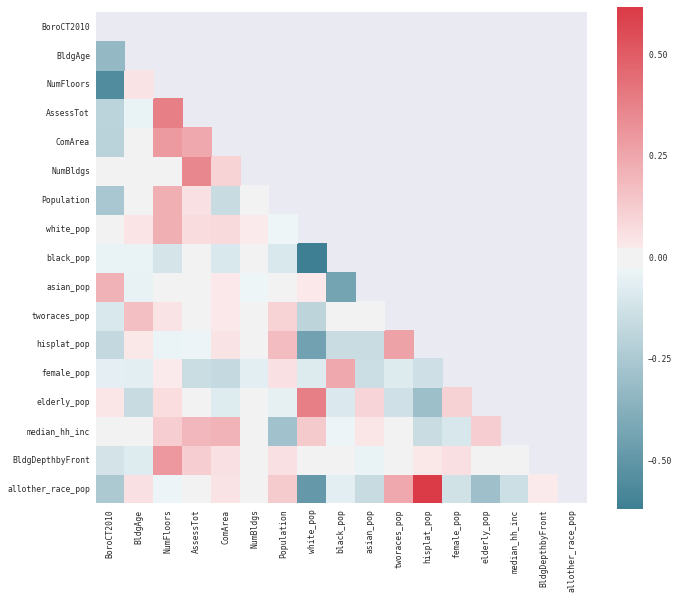

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

sns.set(context="paper", font="monospace")

corr = features.iloc[1:,:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, ax=ax)

### create dataframes for export and analysis

In [34]:
data['year']['ct'] = data['year']['ct'].astype(str)
features['BoroCT2010'] = features['BoroCT2010'].astype(str)
year = pd.merge(features, data['year'], left_on='BoroCT2010', right_on='ct', how='left')
year['comps_perperson'] = year['counts'].div(year['Population'])
print len(year.ct.unique())
print len(data['year']['ct'].unique())
print len(year.BoroCT2010.unique())
year = year.drop('Population',axis=1)
year = year.dropna()
year.to_csv('../output/year_data.csv')

2127
2161
2127


In [35]:
year.isnull().sum()

BoroCT2010           0
BldgAge              0
NumFloors            0
AssessTot            0
ComArea              0
NumBldgs             0
white_pop            0
black_pop            0
asian_pop            0
tworaces_pop         0
hisplat_pop          0
female_pop           0
elderly_pop          0
median_hh_inc        0
BldgDepthbyFront     0
allother_race_pop    0
counts               0
ct                   0
year                 0
comps_perperson      0
dtype: int64

In [36]:
data['month']['ct'] = data['month']['ct'].astype(str)
features['BoroCT2010'] = features['BoroCT2010'].astype(str)
month = pd.merge(features, data['month'], left_on='BoroCT2010', right_on='ct', how='left')
month['comps_perperson'] = month['counts'].div(month['Population'])
print len(month.ct.unique())
print len(data['month']['ct'].unique())
month = month.drop('Population',axis=1)
month = month.dropna()
month.to_csv('../output/month_data.csv')

2127
2161


In [37]:
month.isnull().sum()

BoroCT2010           0
BldgAge              0
NumFloors            0
AssessTot            0
ComArea              0
NumBldgs             0
white_pop            0
black_pop            0
asian_pop            0
tworaces_pop         0
hisplat_pop          0
female_pop           0
elderly_pop          0
median_hh_inc        0
BldgDepthbyFront     0
allother_race_pop    0
counts               0
ct                   0
month                0
comps_perperson      0
dtype: int64

In [38]:
data['month'].head()

,counts,ct,month
0,30,4122300,6
1,114,1002202,6
2,24,3002000,1
3,166,3044100,7
4,192,2040100,3


In [39]:
data['hour']['ct'] = data['hour']['ct'].astype(str)
features['BoroCT2010'] = features['BoroCT2010'].astype(str)
hour = pd.merge(features, data['hour'], left_on='BoroCT2010', right_on='ct', how='left')
hour['comps_perperson'] = hour['counts'].div(hour['Population'])
print len(hour.ct.unique())
print len(data['hour']['ct'].unique())
hour = hour.dropna()
hour = hour.drop('Population',axis=1)
hour.to_csv('../output/hour_data.csv')

2127
2161


In [40]:
hour.isnull().sum()

BoroCT2010           0
BldgAge              0
NumFloors            0
AssessTot            0
ComArea              0
NumBldgs             0
white_pop            0
black_pop            0
asian_pop            0
tworaces_pop         0
hisplat_pop          0
female_pop           0
elderly_pop          0
median_hh_inc        0
BldgDepthbyFront     0
allother_race_pop    0
counts               0
ct                   0
hour                 0
comps_perperson      0
dtype: int64

In [41]:
data['hour'].head()

,counts,ct,hour
0,3,4122300,6
1,22,1002202,6
2,19,3048800,20
3,28,3002000,1
4,10,3042400,20


In [42]:
allc = pd.DataFrame(year['counts'].groupby(year['BoroCT2010']).sum()).reset_index()
allc = pd.merge(allc, features, on='BoroCT2010', how='right')
allc['comps_perperson'] = allc['counts'].div(allc['Population'])
print len(allc.BoroCT2010.unique())
allc = allc.drop('Population',axis=1)
allc = allc.dropna()
allc.to_csv('../output/all_data.csv')

2127


### testing outputs

In [43]:
read_all = pd.read_csv('../output/all_data.csv')
read_all = read_all.drop('Unnamed: 0',axis=1)
print read_all.isnull().sum()
print len(read_all)
read_all.head()

BoroCT2010           0
counts               0
BldgAge              0
NumFloors            0
AssessTot            0
ComArea              0
NumBldgs             0
white_pop            0
black_pop            0
asian_pop            0
tworaces_pop         0
hisplat_pop          0
female_pop           0
elderly_pop          0
median_hh_inc        0
BldgDepthbyFront     0
allother_race_pop    0
comps_perperson      0
dtype: int64
2101


,BoroCT2010,counts,BldgAge,NumFloors,AssessTot,ComArea,NumBldgs,white_pop,black_pop,asian_pop,tworaces_pop,hisplat_pop,female_pop,elderly_pop,median_hh_inc,BldgDepthbyFront,allother_race_pop,comps_perperson
0,1000201,725.0,104.861111,5.444444,2.597126e+06,0.431231,1.166667,0.113221,0.041562,0.341455,0.007166,0.251881,0.533859,0.210319,7.352562,4926.061449,0.150125,0.259764
1,1000202,2264.0,87.530612,5.862245,7.336789e+06,0.703564,3.673469,0.166967,0.123198,0.231720,0.024073,0.239959,0.573378,0.205458,3.821318,8921.366638,0.101828,0.291452
2,1000600,1626.0,92.378205,5.410256,2.117196e+06,0.312833,1.153846,0.031464,0.033296,0.425522,0.004301,0.211725,0.524773,0.236498,1.582205,2682.086887,0.173172,0.129520
3,1000700,3892.0,82.380282,22.848592,3.862563e+07,0.795166,1.154930,0.517171,0.023880,0.164771,0.002729,0.050603,0.520810,0.017626,13.400159,15137.844345,0.025927,0.442574
4,1000800,1458.0,99.950450,5.087838,1.019375e+06,0.356954,1.067568,0.045959,0.008875,0.668251,0.005917,0.028632,0.513788,0.173693,2.867089,2381.887370,0.034760,0.154041
